# GS wavefunction and energy of 1dJ1J2
Solving under PBC, assuming TRS complex wavefunction.
Solution for J1=0 case is shown for demonstration and comparison with 1d AFH.

Codes by Nobuyuki Yoshioka, Feb 2018.

## Load the modules

In [1]:
from RBM_1dJ1J2 import * # RBM class
from MetropolisSamplingTools import * # Markov chain generator class
from VMC_1dJ1J2 import * # VMC scheme class

## Parameters

In [2]:
# System and hidden layer size
n_vis = 8 # system size
alpha = 4 # ratio of #hidden to #visible
n_batch = 400 # (#sample) for Gibbs sampling

# Parameters of Hamiltonian
J1 = 0 # NN AF Heisenberg
J2 = 1 # NNN AF Heisenberg
Delta = 1 # XXZ Anisotropy


# Learning hyperparameters
eta0 = 1e-1 # learning rate
power = 2.5
sigma = 0.01 # amplitude of random init. param
l2reg = 0. # L2 regularization

# Learning schedule
Initlamb = 100 
decay = 0.995
lambmin = 1e-2

Initlamb2 = 1e-2
decay2 = 0.995
#decay2 = 1
lamb2min = 1e-4
print "Lamb2 switch at iter = %d"%(np.log(lamb2min/Initlamb2)/np.log(decay2))

# Other optimization technique
momentum = 0.
dropout_p  = 0.
threshold = 0.3 # threshold for S-matrix.

Lamb2 switch at iter = 918


## Loading analytical expression of wave function

In [3]:
# Here, we use the Gauge-transformed Hamiltonian
# so that wave function is positive semi definite,
# allowing the alternate sampling from RBM.
from plottools_1dJ1J2 import *
from ComplexWFtools import *
from ExactWaveFunc_1dJ1J2 import GSvecs
from ExactWaveFunc_1dJ1J2 import EnPerSite_exact

# Prepare the basis of the vector.
# { |All up>, |uu...ud>, |uu...du>, ..., |All down>}

#Define when it is undefined
if n_vis <=10:
    if not any(map(lambda x:x == 'deggsvec_exact', locals())):
        deggsvec_exact = GSvecs(leng = n_vis, PBCflag = 1, J1 = J1, J2 = J2)
    # Define again when n_vis is changed
    if any(map(lambda x:x == 'vmc', locals())):
        if int(np.log2(len(deggsvec_exact))) != n_vis or (J1, J2) != (vmc.J1, vmc.J2):
            deggsvec_exact = GSvecs(leng = n_vis, PBCflag = 1, J1 = J1, J2 = J2)
            
else:
    gsvec_exact = [None]

if not any(map(lambda x:x == 'enpersite_exact', locals())):
    if n_vis <= 10:
        enpersite_exact = EnPerSite_exact(n_vis, PBCflag = 1, J1 = J1, J2 = J2)/(n_vis*1.0)
    else:
        enpersite_exact = -1.5
if int(np.log2(len(deggsvec_exact))) != n_vis:
    if n_vis <= 10:
        enpersite_exact = EnPerSite_exact(n_vis, PBCflag = 1, J1 = J1, J2 = J2)/(n_vis*1.0)
    else:
        enpersite_exact = -1.5


In [4]:
# Fixing the random seed
seeds = np.array([ 10, 100, 1000, 1234, 12345])
n_seed = len(seeds)
seed = seeds[4]

np.random.seed(seed)
params = np.array([n_vis, alpha,n_batch, J1, J2,  Delta, eta0, power,  sigma, l2reg, Initlamb, decay, lambmin, Initlamb2, decay2, lamb2min,
                      momentum, dropout_p, threshold, seed])
param_contents = ['n_vis', 'alpha' , 'n_batch', 'J1', 'J2',  'Delta', 'eta0','power', 'sigma', 'l2reg', 'Initlamb', 'decay', 'lambmin', 'Initlamb2', 'decay2', 'lamb2min',
                      'momentum', 'dropout_p', 'threshold', 'seed']

vmc = VMC(n_vis = n_vis, alpha = alpha, eta = eta0,  J1 = J1, J2 = J2, sigma = sigma, n_batch = n_batch, deggsvec_exact= deggsvec_exact, threshold = threshold)

vmc.SetRBM()

# Optimizing GS energy by VMC

In [43]:
%%time

import copy 
n_iter = 600

EnPerSite = []
Acceptance_chain = []
vmc.lamb = np.max(np.array([Initlamb , lambmin]))
vmc.lamb2 = np.max(np.array([Initlamb2 , lamb2min]))
for i in range(n_iter):
    vmc.lamb = np.max([Initlamb * decay **i, lambmin])
    vmc.lamb2 = np.max([Initlamb2 * decay2**i, lamb2min])
    vmc.eta = eta0 * ((n_iter - i)/(n_iter*1.0))**power
    
    vmc.run()
    if vmc.elocpersite != vmc.elocpersite:
        print "Divergence in calculation."
        break
    EnPerSite.append(vmc.elocpersite)
    acceptance_mean = np.array(vmc.acceptances).mean()
    Acceptance_chain.append(acceptance_mean)

    if i%10 == 0:
        print "%d th iteration."%i
        vmc.PrintStats()
        print "overlap = ", vmc.overlaps[-1]

EnPerSite = np.array(EnPerSite)

# save the result with timestamp
d = datetime.datetime.today()

directory = 'Result/'
compflag = int(isinstance(vmc.rbm.a[0],complex)) # if the parameters are complex or not
Tsymmflag = int(hasattr(vmc.rbm, 'Wf')) # if the wavefunction is TRS or not

# Decide the name of the file according to the RBM type
predatename = PredateName(vmc,compflag, Tsymmflag)

# save the result
save_yaml(vmc, EnPerSite, params, param_contents, directory, predatename, d)

0 th iteration.
Eloc/site =  (0.9991352150633909-0.0008055247803932836j)
overlap =  [2.6885439773306515e-06, 1.242853349118339e-05]
10 th iteration.
Eloc/site =  (0.9987253620173858+0.00025923785671418397j)
overlap =  [7.360310409197541e-06, 2.68674609387419e-05]
20 th iteration.
Eloc/site =  (0.9996806216811409+0.001821085965028233j)
overlap =  [5.220029529814986e-05, 9.048675484179188e-05]
30 th iteration.
Eloc/site =  (0.9999520012825097+0.010059635299122252j)
overlap =  [0.0011805334828215172, 0.0004909595682383025]
40 th iteration.
Eloc/site =  (0.8991789760026427-0.03250448305456767j)
overlap =  [0.05068396577539615, 0.0034462763322459424]
50 th iteration.
Eloc/site =  (-0.4990529637644399-0.02800186688668628j)
overlap =  [0.5496653777787996, 0.00977316212042522]
60 th iteration.
Eloc/site =  (-1.0062455285337193-0.05024835065221279j)
overlap =  [0.6898346771649382, 0.006457001257614313]
70 th iteration.
Eloc/site =  (-1.068911850772725-0.0008378401597784313j)
overlap =  [0.70203

Loading Result/1dJ1J2_complex_Tsymm_8_4_20171209_181541.yml...


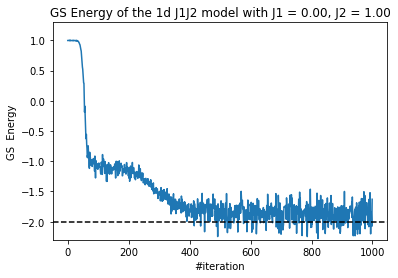

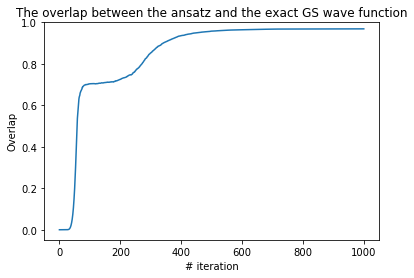

In [6]:
# load and plot the result
#yamlname = directory + predatename + d.strftime("%Y%m%d_%H%M%S")
yamlname = "Result/1dJ1J2_complex_Tsymm_8_4_20171209_181541"

plot_yaml(yamlname)